In [49]:
import re
import random
import pandas as pd
import hashlib

In [50]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [51]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,670.989850,21.644834,30.264311,31
"Mexican Gothic, Moreno-Garcia",1013.407250,36.193116,61.189386,28
Azure Functions Core Tools,693.219798,40.777635,55.652058,17
C# Basics,53.661875,53.661875,53.661875,1
Django,2380.984559,59.524614,80.037209,40
Node.js and Vite,2456.235951,59.908194,86.100965,41
Python,5341.610814,68.482190,181.909017,78
Azure Files Documentation,4376.962973,72.949383,160.553298,60
Active Directory and Azure Files,2907.306393,78.575848,121.429067,37
CCH Tax Forms Project,1702.639897,81.078090,150.685117,21


# Histogram

sum of ages: ~53177.82


<Axes: >

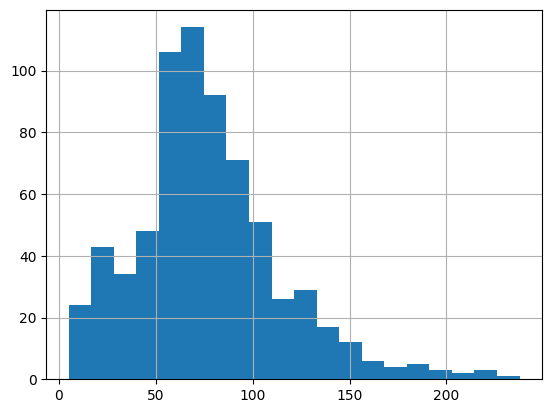

In [52]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53177.82


<Axes: >

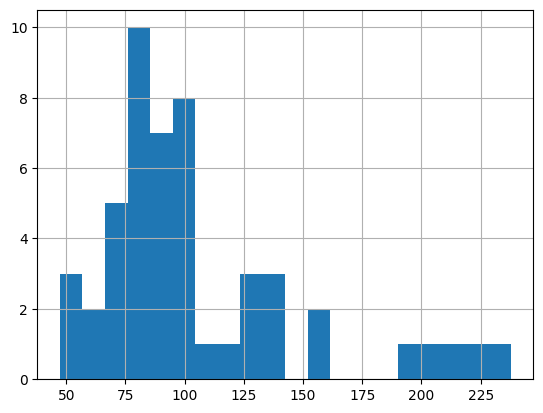

In [53]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='JavaScript Concepts']['age'].hist(bins=20)

# Completely Random Shuffle

In [54]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [55]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [56]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [57]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [58]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [59]:
n=5
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 691
Total card age: 53177.82


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
103,C# Basics,How do basic data types work in C#?\n\nC#: Sta...,9bcbb2098a72dbaa4a613d64f34446be,53.661875,53.661875,-53.661875,53.661875,0.720359,1,0,0,-53.661875
75,Azure VM + Developer,.ssh/known_hosts\nA file used by SSH to store ...,d4f9279a08485d568b293f2c2f417297,131.489922,100.633851,-131.489922,301.901554,0.049530,3,0,0,-131.489922
76,Azure VM + Developer,Makefile / Task Runner\nA scriptable command l...,1d82509533a1c1268c27521f159ed808,100.759235,100.633851,-131.489922,301.901554,0.049530,3,1,0,-100.759235
77,Azure VM + Developer,Inbound NAT Rule\nA networking rule used with ...,3d25b6d3bb4c6bcfe75bca0cb6a22ddc,69.652397,100.633851,-131.489922,301.901554,0.049530,3,2,0,-69.652397
40,Azure Compute Gallery,Cross-Subscription Sharing – ACG images can be...,de0e14f5d2c232476acc689c26c4078f,163.144736,97.994145,-163.144736,783.953159,0.131007,8,0,0,-163.144736
41,Azure Compute Gallery,Azure DevOps Pipelines for Image Deployment – ...,7f9dc58f909efc213b64a0697735712c,152.666218,97.994145,-163.144736,783.953159,0.131007,8,1,0,-152.666218
42,Azure Compute Gallery,Replication Time Constraints – Image replicati...,f5615ce9f50e2f668a32d12784e21991,112.246740,97.994145,-163.144736,783.953159,0.131007,8,2,0,-112.246740
43,Azure Compute Gallery,Image Retention Policy – A strategy for keepin...,70c2d698cafb110aac81fc77dbba5e31,96.918403,97.994145,-163.144736,783.953159,0.131007,8,3,0,-96.918403
44,Azure Compute Gallery,Azure Marketplace Image as a Base – Using a pr...,0d150bb03591ea0166f17b89e7412ee1,81.853516,97.994145,-163.144736,783.953159,0.131007,8,4,0,-81.853516
30,pfSense,"To check for updates to pfSense software, navi...",438fd54e363098f3194d6e2a852d90ee,176.588696,92.163353,-176.588696,1105.960237,0.645949,12,0,0,-176.588696



## Random

In [60]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [61]:
existing_cards.head(10)['age'].sum()

np.float64(1138.9817378365008)

In [62]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,237.735484,104.626312,-237.735484,5231.315583,0.859263,50,0,0,-237.735484
5,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,223.266189,98.340321,-223.266189,1966.806426,0.319504,20,0,0,-223.266189
1,JavaScript Concepts,Express.js: A minimalist web framework for Nod...,425c10164d26897fdad3f9d7c2c6f523,221.368147,104.626312,-237.735484,5231.315583,0.859263,50,1,0,-221.368147
10,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,219.899650,83.097984,-219.899650,4154.899194,0.464250,50,0,0,-219.899650
15,Vocab,"Something Rotten, Fforde\nSalver\nnoun | SAL-v...",c8d10134bc737eb530dfa3f6d3e44e00,213.275194,100.991120,-213.275194,2221.804641,0.187404,22,0,0,-213.275194
2,JavaScript Concepts,Many operators coerce the operands into number...,c7910dc971abc5da390f0193c2ffbdc8,212.927781,104.626312,-237.735484,5231.315583,0.859263,50,2,0,-212.927781
11,Microsoft Purview,Run the policy in simulation mode with notific...,3a95ac540d1e377383ba60aeb1da4f08,200.980756,83.097984,-219.899650,4154.899194,0.464250,50,1,0,-200.980756
3,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,200.707154,104.626312,-237.735484,5231.315583,0.859263,50,3,0,-200.707154
4,JavaScript Concepts,Logical AND (&&) and OR (||) Statements\nif (c...,8541c9ae716e3f5474869ab92784fcc8,197.713224,104.626312,-237.735484,5231.315583,0.859263,50,4,0,-197.713224
6,PnP PowerShell,OAuth 2.0 Client Credentials Flow\nAn authenti...,c90c2d49a1ca2f62bae14c4a35f4e965,188.733187,98.340321,-223.266189,1966.806426,0.319504,20,1,0,-188.733187


In [63]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 76.958'